# 6: Predictive Modeling

In [74]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import RidgeCV, LassoCV, ElasticNetCV
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import GridSearchCV, KFold
import re
import warnings 
warnings.filterwarnings("ignore")
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LinearRegression

### Feature Engineering

In [75]:
# load the dataset
df = pd.read_csv('test_labeled_1.csv')

# convert date ti datetime
df['date'] = pd.to_datetime(df['date'])

# Sentiment score mapping
sentiment_map = {'Positive': 1, 'Negative': -1, 'Neutral': 0}
df['sentiment_score'] = df['sentiment'].map(sentiment_map)

# Basic features
df['body_length'] = df['body'].astype(str).apply(len)
df['word_count'] = df['body'].astype(str).apply(lambda x: len(x.split()))
df['avg_word_length'] = df['body_length'] / df['word_count'].replace(0, np.nan)
df['exclaim_count'] = df['body'].astype(str).apply(lambda x: x.count('!'))

# Positive/Negative term counts
positive_terms = ['great', 'thank', 'happy', 'excellent', 'appreciate']
negative_terms = ['issue', 'delay', 'frustrated', 'problem', 'complain']

df['pos_term_count'] = df['body'].astype(str).apply(lambda x: sum(word in x.lower() for word in positive_terms))
df['neg_term_count'] = df['body'].astype(str).apply(lambda x: sum(word in x.lower() for word in negative_terms))

# Monthly message count and sentiment ratio
df['month_period'] = df['date'].dt.to_period('M')
df['msg_count_month'] = df.groupby(['from', 'month_period'])['body'].transform('count')

monthly_sentiment = df.groupby(['from', 'month_period'])['sentiment'].value_counts().unstack(fill_value=0)
monthly_sentiment['sentiment_ratio'] = monthly_sentiment.get('Positive', 0) / (monthly_sentiment.get('Negative', 1))
df = df.merge(monthly_sentiment['sentiment_ratio'], on=['from', 'month_period'], how='left')


features = [
    'body_length', 'word_count', 'avg_word_length', 'exclaim_count',
    'pos_term_count', 'neg_term_count', 'msg_count_month', 'sentiment_ratio'
]



### Model Development

In [78]:
# Split data into feature variables X and target variables Y
X = df[features].fillna(0)
y = df['sentiment_score']

X['sentiment_ratio'] = X['sentiment_ratio'].replace([np.inf, -np.inf], np.nan).fillna(1.0)
assert np.isfinite(X.values).all(), "Feature matrix still contains non-finite values!"

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', ElasticNet())
])

# Parameter Grid
param_grid = {
    'regressor__alpha': [0.01, 0.1, 1.0, 10.0],
    'regressor__l1_ratio': [0.2, 0.5, 0.8]  # 0 = Ridge-like, 1 = Lasso-like
}
# Hyperparameter Tuning
cv = KFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(pipeline, param_grid, cv=cv, scoring='r2')
grid_search.fit(X, y)

# Train model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X)

# Evaluation
rmse = mean_squared_error(y, y_pred, squared=False)
r2 = r2_score(y, y_pred)

print(f'Best Alpha: {grid_search.best_params_["regressor__alpha"]}')
print(f'RMSE: {rmse:.3f}')
print(f'R² Score: {r2:.3f}')

Best Alpha: 0.01
RMSE: 0.616
R² Score: 0.175


In [79]:
coefficients = pd.DataFrame({
    'Feature': features,
    'Coefficient': best_model.named_steps['regressor'].coef_
}).sort_values(by='Coefficient', ascending=False)
print(coefficients)

           Feature  Coefficient
4   pos_term_count     0.199700
1       word_count     0.086743
2  avg_word_length     0.078639
7  sentiment_ratio     0.031504
0      body_length     0.027518
3    exclaim_count     0.000000
5   neg_term_count    -0.000000
6  msg_count_month    -0.026475


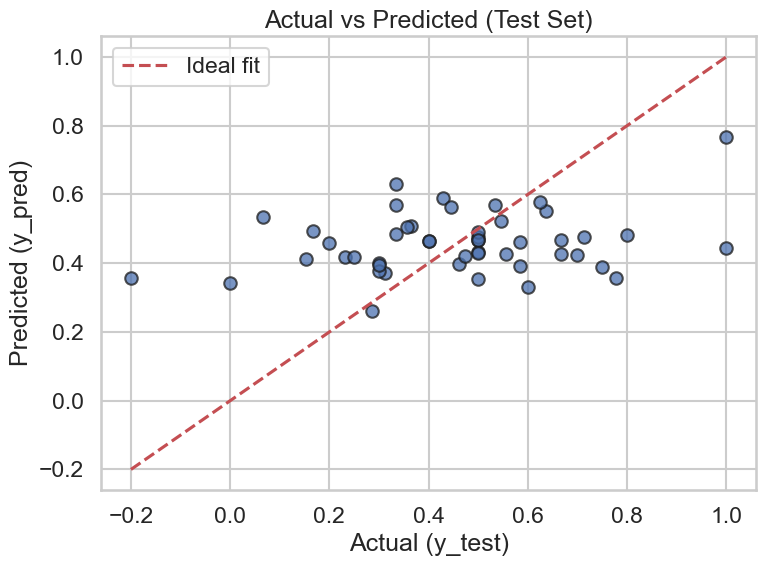

In [81]:
sns.set(style="whitegrid", context="talk")

# Predictions and residuals
y_pred = best_model.predict(X_test_aligned)
residuals = y_test - y_pred

# 1) Actual vs Predicted
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.75, edgecolor='k')
lims = [min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())]
plt.plot(lims, lims, 'r--', label='Ideal fit')
plt.xlabel('Actual (y_test)')
plt.ylabel('Predicted (y_pred)')
plt.title('Actual vs Predicted (Test Set)')
plt.legend()
plt.tight_layout()
plt.show()

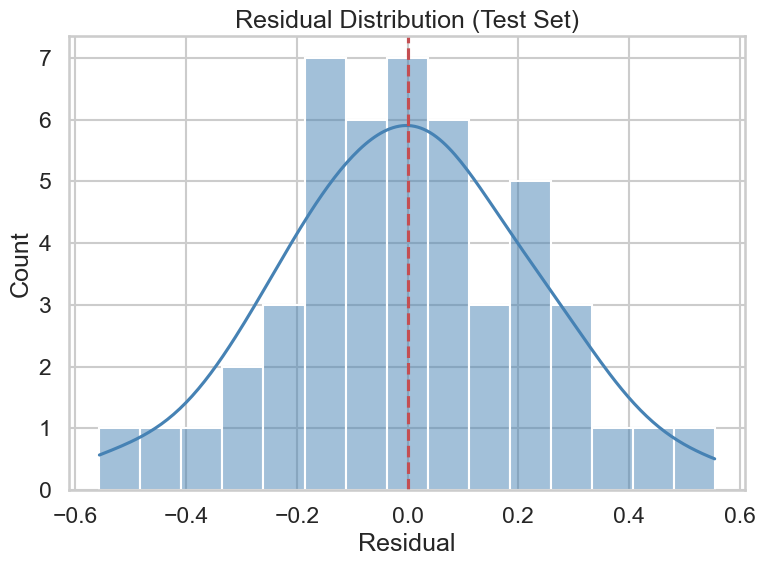

In [82]:
#Residual distribution
plt.figure(figsize=(8, 6))
sns.histplot(residuals, kde=True, bins=15, color='steelblue')
plt.axvline(0, color='r', linestyle='--')
plt.xlabel('Residual')
plt.title('Residual Distribution (Test Set)')
plt.tight_layout()
plt.show()

# Summary





## Features Used: 
### word_count 		 - Number of words in the message 
### avg_word_length	 - Average word length
### exclaim_count		 - Number of exclamation marks
### pos_term_count	 - Count of positive terms (e.g., "great", "thank", "happy")
### neg_term_count	 - Count of negative terms (e.g., "issue", "delay", "frustrated")
### msg_count_month	 - Number of messages sent by employee in the month
### sentiment_ratio	 - Ratio of positive to negative messages per employee per month
### body_length		 - Total character count of the message

### Target Variable: Sentiment_Score (median of ±1/0 sentiment scores)

## Training Method: 80/20 Train–Test split

## Evaluation Metrics:
### RMSE 0.616 - Predictions deviate by ~0.6 points from actual values
### R² 0.175 - Model explains ~17.5% of the variance in sentiment trends


